# How to cross-validate a parameterized trading strategy

Trading strategies often rely on parameters. Enhancing and effectively cross-validating these parameters can provide a competitive advantage in the market. However, creating a reliable cross-validation schema is challenging due to risks like look-ahead bias and other pitfalls that can lead to overestimating a strategy's performance. With [VectorBT PRO](https://vectorbt.pro/), you can easily access and implement a variety of sophisticated cross-validation methods with just a few lines of code.

## Imports and data

Let's import VBT PRO and the few libraries relevant for our analysis.

In [1]:
from vectorbtpro import *
# whats_imported()

vbt.settings.set_theme("dark")

The first step involves acquiring data.

In [2]:
SYMBOL = "AAPL"
START = "2010"
END = "now"
TIMEFRAME = "day"

data = vbt.YFData.pull(SYMBOL, start=START, end=END, timeframe=TIMEFRAME)

## Cross-validation schema

Next, we'll set up a "splitter," which divides a date range into smaller segments according to a chosen schema. For instance, let's allocate 12 months for training data and another 12 months for testing data, with this cycle repeating every 3 months.

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



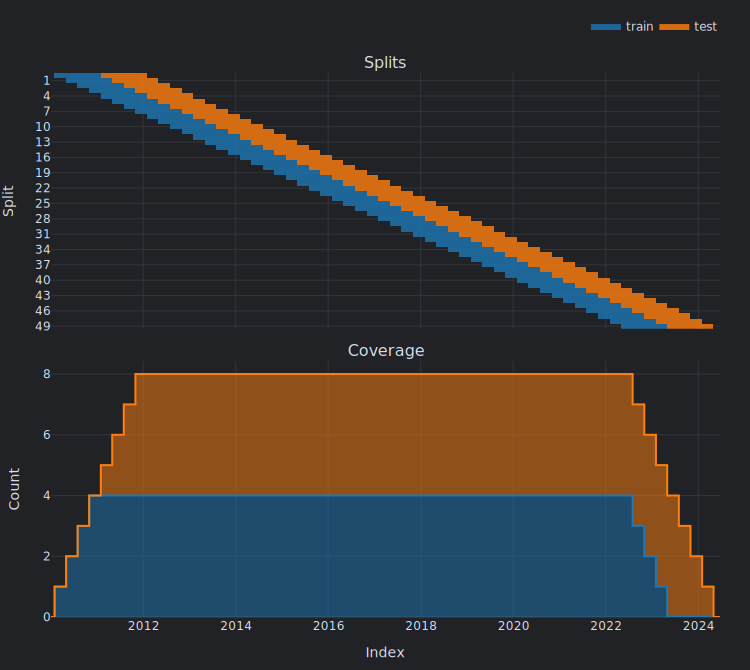

In [5]:
TRAIN = 12
TEST = 12
EVERY = 3
OFFSET = vbt.offset("M")

splitter = vbt.Splitter.from_ranges(
    data.index, 
    every=EVERY * OFFSET, 
    lookback_period=(TRAIN + TEST) * OFFSET,
    split=(
        vbt.RepFunc(lambda index: index < index[0] + TRAIN * OFFSET),
        vbt.RepFunc(lambda index: index >= index[0] + TRAIN * OFFSET),
    ),
    set_labels=["train", "test"]
)
splitter.plots().show_svg()

In the first subplot, we see that each split (or row) contains adjacent training and testing sets, progressively rolling from past to present. The second subplot illustrates the overlap of each data point across different ranges. Tip: For non-overlapping testing sets, use the setting `EVERY = TRAIN`.

## Objective function

Next, we'll create a function to execute a trading strategy within a specified date range using a single parameter set, returning one key metric. Our strategy will be a simple EMA crossover combined with an ATR trailing stop.

In [6]:
def objective(data, fast_period=10, slow_period=20, atr_period=14, atr_mult=3):
    fast_ema = data.run("talib:ema", fast_period, short_name="fast_ema", unpack=True)
    slow_ema = data.run("talib:ema", slow_period, short_name="slow_ema", unpack=True)
    atr = data.run("talib:atr", atr_period, unpack=True)
    pf = vbt.PF.from_signals(
        data, 
        entries=fast_ema.vbt.crossed_above(slow_ema), 
        exits=fast_ema.vbt.crossed_below(slow_ema), 
        tsl_stop=atr * atr_mult, 
        save_returns=True,
        freq=TIMEFRAME
    )
    return pf.sharpe_ratio

print(objective(data))

1.2372840983046243


## Parameter optimization

Let's harness the power of VBT PRO! By decorating (or wrapping) our function with `parameterized`, we enable `objective` to accept a list of parameters and execute them across all combinations. We'll then further enhance the function with another decorator, `split`, which runs the strategy on each date range specified by the splitter. This approach allows us to apply our strategy across every possible date range and parameter combination, compiling the outcomes into a single Pandas Series.

In [10]:
param_objective = vbt.parameterized(
    objective,
    merge_func="concat",
    mono_n_chunks="auto",  # merge parameter combinations into chunks
    execute_kwargs=dict(warmup=True, engine="pathos")  # run chunks in parallel using Pathos
)
cv_objective = vbt.split(
    param_objective,
    splitter=splitter, 
    takeable_args=["data"],  # select date range from data
    merge_func="concat", 
)

sharpe_ratio = cv_objective(
    data,
    vbt.Param(np.arange(10, 50), condition="slow_period - fast_period >= 5"),
    vbt.Param(np.arange(10, 50)),
    vbt.Param(np.arange(10, 50), condition="fast_period <= atr_period <= slow_period"),
    vbt.Param(np.arange(2, 5))
)
print(sharpe_ratio)

  0%|          | 0/50 [00:08<?, ?it/s, split=0]

split  set    fast_period  slow_period  atr_period  atr_mult
0      train  10           15           10          2           0.475209
                                                    3           0.475209
                                                    4           0.475209
                                        11          2           0.475209
                                                    3           0.475209
                                                                  ...   
49     test   44           49           48          3          -0.340057
                                                    4          -0.340057
                                        49          2          -0.340057
                                                    3          -0.340057
                                                    4          -0.340057
Name: sharpe_ratio, Length: 3276000, dtype: float64


We tested over 3 million combinations of date ranges and parameters in just a few minutes.

## Analysis

Let's find out if there's a correlation between the results of the training and testing sets.

In [11]:
train_sharpe_ratio = sharpe_ratio.xs("train", level="set")
test_sharpe_ratio = sharpe_ratio.xs("test", level="set")
print(train_sharpe_ratio.corr(test_sharpe_ratio))

-0.2121882686485464


The analysis indicates a weak negative correlation or no substantial correlation. This suggests that the strategy tends to perform oppositely compared to its results in previous months.

And here's an analysis segmented by fast and slow EMA periods. It highlights the minimal variation in the Sharpe ratio from the training to the testing set across at least 50% of the splits, where blue indicates a positive change.

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



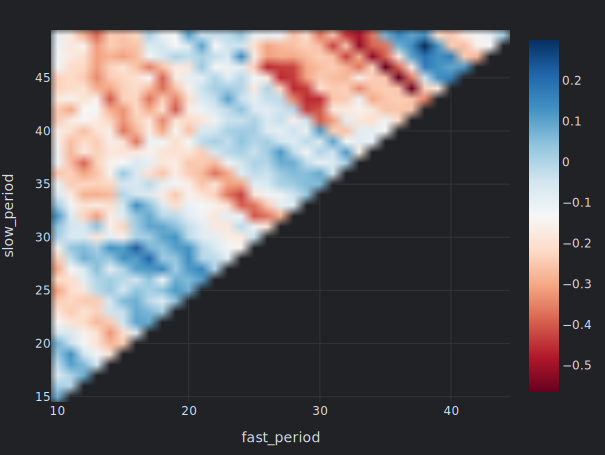

In [12]:
sharpe_ratio_diff = test_sharpe_ratio - train_sharpe_ratio
sharpe_ratio_diff_median = sharpe_ratio_diff.groupby(["fast_period", "slow_period"]).median()
sharpe_ratio_diff_median.vbt.heatmap(trace_kwargs=dict(colorscale="RdBu")).show_svg()

## Conclusion

Although you might have developed a promising strategy on paper, cross-validating it is essential to confirm its consistent performance over time and to ensure it's not merely a result of random fluctuations.